In [180]:
from sklearn.base import clone 
from itertools import combinations 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


class SBS:
    def __init__(self, estimator, k_features, scoring = accuracy_score,
                    test_size = 0.25, random_state = 1):
        self.scoring = scoring
        self.estimator = estimator
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
    def fit(self, x, y ):
        x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                test_size = self.test_size,
                                                random_state = self.random_state)
        dim = x_train.shape[1]
        self.indices_ = tuple( range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(x_train,y_train,x_test,y_test,self.indices_)
        
        self.scores_ = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r = dim - 1):
                score = self._calc_score(x_train,y_train,x_test,y_test,p)
                scores.append(score)
                subsets.append(p)
                
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -=1
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        
        return self
    def transform(self,x):
        return x[:,self.indices_]
    
    def _calc_score(self,x_train,y_train,x_test,y_test,indices):
        
        self.estimator.fit(x_train[:, indices], y_train)
        y_pred = self.estimator.predict(x_test[:,indices])
        score = self.scoring(y_test,y_pred)

        return score 
    

In [181]:
from sklearn.datasets import load_wine
data = load_wine()
x = data.data
y = data.target
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                test_size = 0.3,
                                                random_state = 0)

from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
x_train_std = stdsc.fit(x_train)
x_test_std = stdsc.transform(x_test)

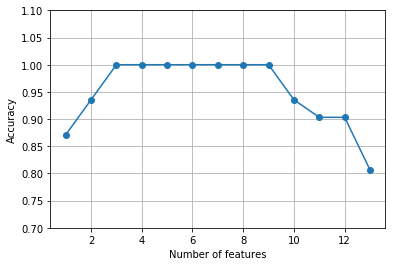

In [182]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt 
knn = KNeighborsClassifier(n_neighbors = 2 )
sbs = SBS(knn,k_features = 1)
sbs.fit(x_train,y_train)

k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat,sbs.scores_,marker = "o")
plt.ylim([0.7,1.1])
plt.ylabel("Accuracy")
plt.xlabel("Number of features")
plt.grid()
plt.show()



In [189]:
from sklearn.ensemble import RandomForestClassifier
feat_labels = """
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline"""
feat_labels = [i.replace("-","").strip() for i in feat_labels.split("\n") if i != ""]

forest = RandomForestClassifier(n_estimators = 10000,random_state = 0, n_jobs = -1)
forest.fit(x_train,y_train)
importances = forest.feature_importances_

indices = np.argsort((importances)[::-1] )


In [190]:
for f in range(x_train.shape[1]):
    print("{0:2d}) {1:<30}  {2:f}".format(f+1,feat_labels[indices[f]],importances[indices[f]]))

 1) Hue                             0.078243
 2) Total phenols                   0.060718
 3) Proanthocyanins                 0.022351
 4) Magnesium                       0.022078
 5) OD280/OD315 of diluted wines    0.131987
 6) Color intensity                 0.182483
 7) Nonflavanoid phenols            0.014645
 8) Ash                             0.013916
 9) Proline                         0.158610
10) Malic acid                      0.025400
11) Flavanoids                      0.150948
12) Alcohol                         0.106589
13) Alcalinity of ash               0.032033


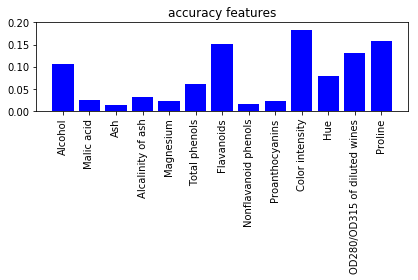

In [222]:
plt.title("accuracy features")
plt.bar(range(x_train.shape[1]), importances, color = "blue",align = "center")

plt.xticks( range(x_train.shape[1]), feat_labels, rotation = 90)
plt.xlim([-1,x_train.shape[1]])
plt.ylim([0,0.2])
plt.tight_layout()
plt.show()

